## Обработка комментариев из Твиттера и классификация их на токсичные/нетоксичные.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math

from sklearn.model_selection import train_test_split

Данные взял из заданий курса по Машинному обучению. Это набор комментариев с маркером should_ban: 0 - если коммент нетоксичный; 1 - если токсичный (значит надо забанить за оскорбления).

In [2]:
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values

Пример данных

In [3]:
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \r\n\r\nI am sorry, but you se..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\r\n\r\nCheck out the Wikipedia:...


Разделим данные на тренировочную и тестовую выборки

In [4]:
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Предобработка данных

Разобьём все твиты на токены, используем для этого TweetTokenizer. Уберём прописные буквы (так как они не несут полезной информации, но токены "My" и "my" считаются разными). 

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(strip_handles=True)  # "strip_handles=True" уберёт ссылки на никнеймы - это слова, начинающиеся
                                                # с символа @. 
                                                # Никнеймы не несут полезной информации при классификации токсичных твитов.

# Уберём прописные буквы
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!". @Man'
print("До токенизации:", text,)
print("После токенизации:", preprocess(text),)

До токенизации: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!". @Man
После токенизации: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


Применим наш токейназер к тренировочной и тестовой выборке.

In [6]:
texts_train = np.array([preprocess(s) for s in texts_train])
texts_test = np.array([preprocess(s) for s in texts_test])

Проверим, что всё работает правильно

In [7]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Решим задачу с помощью метода bag of words

Будем использовать k самых часто встречающихся токенов из тренировочной выборки. 

In [8]:
k = min(10000, len(set(' '.join(texts_train).split())))

texts_train1 = ' '.join(texts_train).split()
texts_train_uniq, texts_train_uniq_count = np.unique(texts_train1, return_counts=True)
texts_train_voc = np.zeros_like(texts_train_uniq)
texts_train_voc_count = np.zeros_like(texts_train_uniq_count)
for i in range(len(texts_train_voc)):
    texts_train_voc[i] = texts_train_uniq[np.argmax(texts_train_uniq_count)]
    texts_train_voc_count[i] = texts_train_uniq_count.max()
    texts_train_uniq = np.delete(texts_train_uniq, np.argmax(texts_train_uniq_count))
    texts_train_uniq_count = np.delete(texts_train_uniq_count, np.argmax(texts_train_uniq_count))


In [9]:
print("Самые часто встречаемые токены")
bow_vocabulary = texts_train_voc[:k]
bow_vocabulary = bow_vocabulary.tolist()
print(bow_vocabulary[:10])
print("Сколько раз встречаются самые частые слова")
print(texts_train_voc_count[:10])

Самые часто встречаемые токены
['.', ',', 'you', 'the', '"', 'a', 'to', 'i', 'and', '!']
Сколько раз встречаются самые частые слова
[1513 1389 1342 1219 1057  860  823  727  711  703]


In [10]:
def text_to_bow(text):
    """ Функция для преобразования предложения в bag of words"""   
    text = text.split()
    text_counts = np.zeros(len(bow_vocabulary))
    for word in text:
        for i in range(len(bow_vocabulary)):
            if word == bow_vocabulary[i]:
                text_counts[i] += 1
                break

    return np.array(text_counts, 'float32')

Преобразуем тренировочную выборку в bag of words

In [11]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

Проверим, что всё сделано правильно

In [12]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Отнормируем данные и применим логистическую регрессию

In [13]:
# Скейлим данные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_bow)
X_train_bow_scaled = scaler.transform(X_train_bow)
X_test_bow_scaled = scaler.transform(X_test_bow)

In [14]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(n_jobs=-1).fit(X_train_bow_scaled, y_train)

Посмотрим, что получилось. Построим ROC кривую

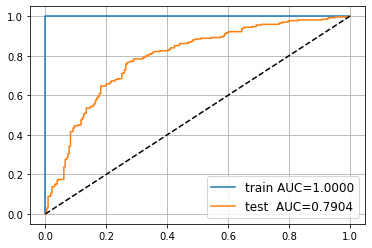

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_scaled, y_train, bow_model),
    ('test ', X_test_bow_scaled, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Попробуем поварьировать k

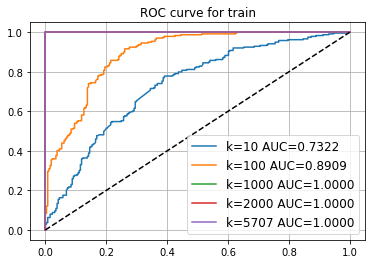

In [16]:
for k in np.hstack((np.array([10, 100, 1000, 2000, min(10000, len(set(' '.join(texts_train).split())))]))):
    del bow_vocabulary
    bow_vocabulary = texts_train_voc[:k]
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    scaler.fit(X_train_bow)
    X_train_bow_scaled = scaler.transform(X_train_bow)
    X_test_bow_scaled = scaler.transform(X_test_bow)
    bow_model.fit(X_train_bow_scaled, y_train)
    for number_of_words, X, y, model in [(k, X_train_bow_scaled, y_train, bow_model)]:
            proba = model.predict_proba(X)[:, 1]
            auc = roc_auc_score(y, proba)
            plt.plot(*roc_curve(y, proba)[:2], label='k=%d AUC=%.4f' % (k, auc))
            plt.title('ROC curve for train')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

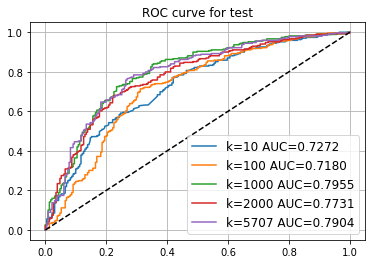

In [17]:
for k in np.hstack((np.array([10, 100, 1000, 2000, min(10000, len(set(' '.join(texts_train).split())))]))):
    del bow_vocabulary
    bow_vocabulary = texts_train_voc[:k]
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    scaler.fit(X_train_bow)
    X_train_bow_scaled = scaler.transform(X_train_bow)
    X_test_bow_scaled = scaler.transform(X_test_bow)
    bow_model.fit(X_train_bow_scaled, y_train)
    for number_of_words, X, y, model in [(k, X_test_bow_scaled, y_test, bow_model)]:
            proba = model.predict_proba(X)[:, 1]
            auc = roc_auc_score(y, proba)
            plt.plot(*roc_curve(y, proba)[:2], label='k=%d AUC=%.4f' % (k, auc))
            plt.title('ROC curve for test')
            

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Использование всех токенов даёт наилучший результат

### Применим метод TF-IDF, чтобы не учитывать местоимения и артикли, которые не несут пользы при классификации

In [18]:
def computeReviewTFDict(review, bow_vocabulary):
    """
    Функция возвращает словарь, в котором из предложения review создаётся TF словарь,
    в котором ключи - это уникальные слова из review, а значения - TF, соответствующее слову по словарю bow_vocabulary.
    """
    # Считаем для каждого слова его встречаемость с помощью bow_vocabulary
    reviewTFDict = dict.fromkeys(bow_vocabulary, 0)
    for word in review:
        if word in reviewTFDict:
            reviewTFDict[word] += 1
        else:
            reviewTFDict[word] = 1
    for word in reviewTFDict:
        reviewTFDict[word] = reviewTFDict[word] / len(review)
    return reviewTFDict

Рассчитаем TF для тренировочной и тестовой выборок

In [19]:
texts_train_split = np.array([s.split() for s in texts_train])
texts_test_split = np.array([s.split() for s in texts_test])

TFDict_train = np.array([computeReviewTFDict(s, bow_vocabulary) for s in texts_train_split])
TFDict_test = np.array([computeReviewTFDict(s, bow_vocabulary) for s in texts_test_split])

<ipython-input-19-9273b899ff27>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  texts_train_split = np.array([s.split() for s in texts_train])
<ipython-input-19-9273b899ff27>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  texts_test_split = np.array([s.split() for s in texts_test])


In [20]:
def computeidfDict(tfDict, bow_vocabulary):
    """
    Функция возвращает словарь, в котором ключи - уникальные слова из предложенного датасета tfDict,
    а значения - соответствующие idf.
    """
    idfDict = dict.fromkeys(bow_vocabulary, 0)
    for review in tfDict:
        for word in idfDict:
            if word in review:
                idfDict[word] += 1
    for word in idfDict:
        if idfDict[word] != 0:
            idfDict[word] = math.log(len(tfDict) / idfDict[word])
    return idfDict

Применим к тестовой и тренировочной выборке

In [21]:
idfDict_train = computeidfDict(texts_train_split, bow_vocabulary)
idfDict_test = computeidfDict(texts_test_split, bow_vocabulary)

In [22]:
def computeReviewTFIDFDict(reviewTFDict, idfDict):
    """
    Функция возвращает словарь с ключами - уникальными словами из reviewTFDict
    и значениями - соответствующими TF-IDF для каждого слова.
    """
    reviewTFIDFDict = dict.fromkeys(bow_vocabulary, 0)
    #For each word in the review, we multiply its tf and its idf.
    for word in reviewTFDict:
        if word in idfDict:
            reviewTFIDFDict[word] = reviewTFDict[word] * idfDict[word]
    return reviewTFIDFDict

Получим TF-IDF для каждого слова

In [23]:
tfidfDict_train = [computeReviewTFIDFDict(review, idfDict_train) for review in TFDict_train]
tfidfDict_test = [computeReviewTFIDFDict(review, idfDict_test) for review in TFDict_test]

In [24]:
# Получим словарь со словами из тренировочной выборки
wordDict = sorted(idfDict_train.keys())

def computeTFIDFVector(review, wordDict):
    """
    Функция рассчитывает вектор длиной такой, сколько слов в wordDict,
    значение каждой координаты - TF-IDF соответствующего слова из review.
    """
    tfidfVector = [0.0] * len(wordDict)
    for i, word in enumerate(wordDict):
        if word in review:
            tfidfVector[i] = review[word]
    return tfidfVector

# Получим вектора для тренировочной и тестовой выборок.
tfidfVector_train = [computeTFIDFVector(review, wordDict) for review in tfidfDict_train]
tfidfVector_test = [computeTFIDFVector(review, wordDict) for review in tfidfDict_test]

Отнормируем вектора и применим логистическую регрессию к новым данным

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(tfidfVector_train)
tfidfVector_train_scaled = scaler.transform(tfidfVector_train)
tfidfVector_test_scaled = scaler.transform(tfidfVector_test)

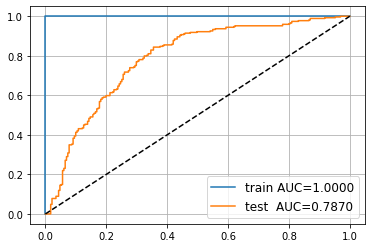

In [26]:
tfidf_model = LogisticRegression(n_jobs=-1)
tfidf_model.fit(tfidfVector_train_scaled, y_train)

for name, X, y, model in [
    ('train', tfidfVector_train_scaled, y_train, tfidf_model),
    ('test ', tfidfVector_test_scaled, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Результат почти не изменился, хотя точность должна была по идее повыситься. Так произошло, потому что обычно в toxic комментах пишут не особо соблюдая нормы языка и грамматики (в том числе и правило артиклей), поэтому при классификации "добрых" комментов возможно модель обращает внимание на артикли в том числе. 